In [1]:
from pytorch_grad_cam import GradCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import torch
from torchvision.transforms import Compose, Normalize, ToTensor
import torchvision.models as models
import os
import time
from PIL import Image
from torchvision import transforms
import torch.nn as nn
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch.nn.functional as F # 소프트맥스 활성화를 위해 추가


In [2]:
model1 = models.resnet50(pretrained=False)
print(model1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

c:\project_aug\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\project_aug\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
weights = torch.load("model/Best_ResNet50_model.pth", map_location=torch.device('cpu'))
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(in_features=2048, out_features=13, bias=True)
model.load_state_dict(weights)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
full_datasets = ImageFolder(root='data/Dataset_project4')
class_names = full_datasets.classes
class_names

['금속캔알루미늄캔',
 '금속캔철캔',
 '비닐',
 '스티로폼',
 '유리병갈색',
 '유리병녹색',
 '유리병투명',
 '종이',
 '페트병무색단일',
 '페트병유색단일',
 '플라스틱PE',
 '플라스틱PP',
 '플라스틱PS']

In [5]:
transforms_train = transforms.Compose([
    # transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    # 무작위 원근 왜곡 추가
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
from sklearn.model_selection import train_test_split
# 데이터 크기와 target 저장 
total_size = len(full_datasets)
targets = full_datasets.targets

train_indices, test_indices = train_test_split(
    np.arange(total_size),
    test_size=0.2,
    stratify=targets,
    random_state=42   
)

train_dataset = torch.utils.data.Subset(full_datasets, train_indices)
test_dataset = torch.utils.data.Subset(full_datasets, test_indices)

print("\n데이터셋 분할 완료.")
print(f"총 데이터 수: {total_size}")
print(f"학습용 데이터 수: {len(train_dataset)}")
print(f"검증용 데이터 수: {len(test_dataset)}")


데이터셋 분할 완료.
총 데이터 수: 69898
학습용 데이터 수: 55918
검증용 데이터 수: 13980


In [7]:
test_dataset.dataset.transform = transforms_test

In [8]:
img, label = test_dataset[0]

print(img.shape)
print(label)
print(len(test_dataset))

torch.Size([3, 512, 512])
0
13980


In [ ]:
target_layer = model.layer4[-1]
target_layer

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [10]:
cam = AblationCAM(model=model, target_layers=[target_layer])
cam.batch_size = 1

In [11]:
# ImageNet 표준 정규화 값 (모델 학습 시 사용한 값과 일치해야 함)
# 만약 다른 값으로 정규화했다면 이 값을 변경해야 합니다.
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

def denormalize_image(tensor_image, mean=NORM_MEAN, std=NORM_STD):
    """
    정규화된 이미지 텐서를 역정규화하여 0-1 범위의 NumPy 배열로 변환합니다.
    """
    for t, m, s in zip(tensor_image, mean, std):
        t.mul_(s).add_(m) # t = t * s + m
    
    # 텐서를 NumPy 배열로 변환하고 채널 순서를 (H, W, C)로 변경
    np_image = tensor_image.numpy().transpose((1, 2, 0))
    
    # 픽셀 값을 0-1 범위로 클리핑하여 유효한 이미지 범위 유지
    np_image = np.clip(np_image, 0, 1)
    
    return np_image


## Label 4 유리병 찾기

In [12]:
# 라벨 4인 이미지를 저장할 리스트
label_4_images_info = []
count = 0

# test_dataset에서 라벨이 4인 이미지 최대 100개를 찾습니다.
for i, (img, label) in enumerate(test_dataset):
    if label == 4:
        label_4_images_info.append((img, label, i)) # (이미지 텐서, 실제 라벨, 원본 인덱스)
        count += 1
        if count >= 3:
            break

라벨이 4인 이미지 3개를 찾았습니다. 시각화를 시작합니다.


100%|██████████| 2048/2048 [05:39<00:00,  6.04it/s]


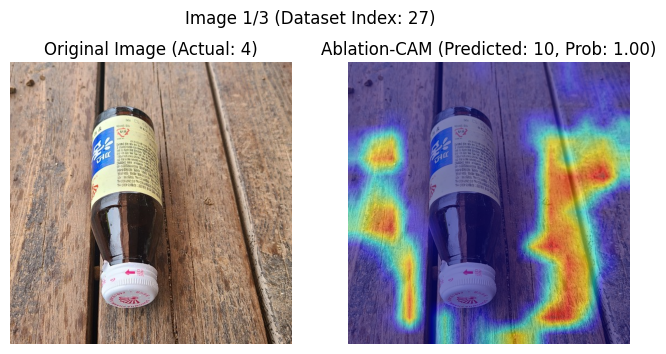

100%|██████████| 2048/2048 [05:22<00:00,  6.35it/s]


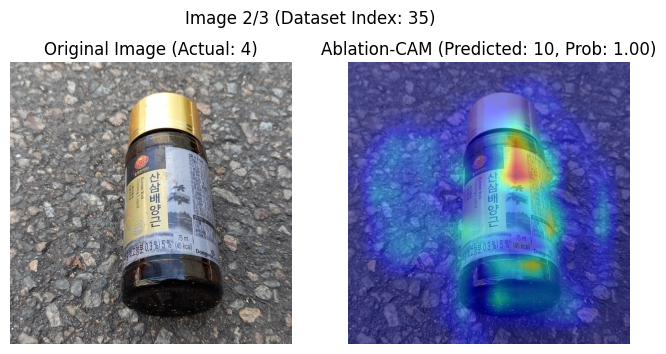

100%|██████████| 2048/2048 [05:27<00:00,  6.26it/s]


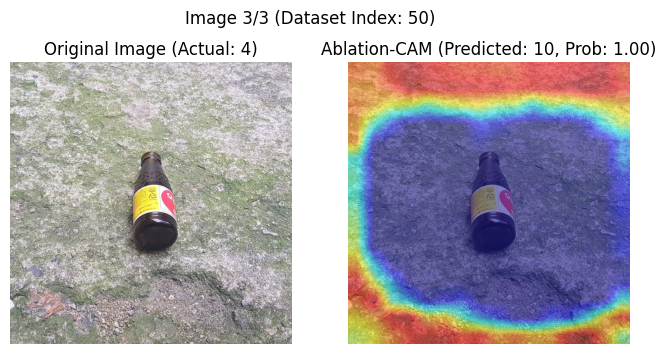

In [13]:
# 모델을 평가 모드로 설정
model.eval()

if not label_4_images_info:
    print("라벨이 4인 이미지를 찾을 수 없습니다.")
else:
    print(f"라벨이 4인 이미지 {len(label_4_images_info)}개를 찾았습니다. 시각화를 시작합니다.")

    # 각 이미지에 대해 Ablation-CAM과 예측을 시각화
    for k, (original_img_tensor, actual_label, original_idx) in enumerate(label_4_images_info):
        
        input_tensor = original_img_tensor.unsqueeze(0)
        
        # 모델 예측 수행
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = F.softmax(output, dim=1) # 소프트맥스로 확률 변환
            predicted_prob, predicted_label = torch.max(probabilities, 1) # 가장 높은 확률과 해당 라벨
        
        # Grad-CAM 인스턴스에 적용할 타겟을 지정합니다. 여기서는 라벨 4에 대한 CAM을 계산합니다.
        # 실제 예측된 라벨에 대한 CAM을 보고 싶다면 targets = [ClassifierOutputTarget(predicted_label.item())] 로 변경
        targets = [ClassifierOutputTarget(4)] 
        
        # Ablation을 계산합니다.
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        
        # 결과를 이미지에 덧입히기 위해 CAM 값을 첫 번째 차원을 제거합니다.
        grayscale_cam = grayscale_cam[0, :]

        # 원본 이미지 텐서를 역정규화하고 NumPy 배열로 변환
        denormalized_rgb_img = denormalize_image(original_img_tensor.cpu())
        
        # CAM 히트맵을 역정규화된 원본 이미지에 덧씌웁니다.
        visualization = show_cam_on_image(denormalized_rgb_img, grayscale_cam, use_rgb=True)

        # 결과 시각화
        plt.figure(figsize=(8, 4)) # 이미지 크기 조정
        
        plt.subplot(1, 2, 1)
        plt.imshow(denormalized_rgb_img)
        plt.title(f"Original Image (Actual: {actual_label})")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(visualization)
        plt.title(f"Ablation-CAM (Predicted: {predicted_label.item()}, Prob: {predicted_prob.item():.2f})")
        plt.axis('off')
        
        plt.suptitle(f"Image {k+1}/{len(label_4_images_info)} (Dataset Index: {original_idx})")
        plt.show()
        
        # 3장만 우선 보고 싶다면, 여기서 break
        if k >= 3: 
           break